## Wrangling
 - What Are we aiming to do with wrangle??
 

### Acquire
 - Where is our data coming from?
 - How do we get it? (AKA how can we make it gettable for others?)

### Prepare
 - What does this data look like?
 - Does the data look like its "supposed to"?
     - do numbers look like numbers, do we see any major errors in the data that could be chalked up to clerical error or otherwise corrupted information?
     - Nulls, Nans, whitespace, other problems
 - If we have problems with our data, how do we deal with it? 
     - Fix the problems, record how you fixed the problems (documentation!!!!)
     - Examine univariate distributions (Understand what exploration is going to look like going forward -- i.e. How Normal* does this data look on first blush?) (* In the distribution sense, and assert how that will impact both our statistical testing, exploration, and use of these variables)
     - script it out into something that can be repeated

#### Step 1: Acquire!
 - We will be using some student grade data
 - Planning: We will be attempting to capture a pattern for final grade based on previous exam work from students, with the hope via our projections that we can identify at-risk students early enough in a program to determine if they are at risk of failure

In [5]:
import numpy as np
import pandas as pd
from env import user, password, host 

In [1]:
# steps:
# I have identified what data I need and 
# where it lives, so let's go ahead and replicate
# that here with python

In [4]:
# pd.read_sql?
# we need a connection and a query.
# first, define our query.

In [10]:
# use our pymysql formatting to establish our connection string
connection = f'mysql+pymysql://{user}:{password}@{host}'

In [12]:
# use the school sample schema in our DB
endpoint = '/school_sample'

In [13]:
connection = connection+endpoint

In [15]:
# take the query that we just tested 
query = 'SELECT * FROM student_grades'

In [17]:
# we can use pd.read_sql
# throw that into a variable
df = pd.read_sql(query, connection)

#### What do we want to know about this data?
 - df.info()
 - info - give us basic information about the features
 - df.describe()
 - describe - basic descriptive statistics
 - size, shape - know how big the thing is
 - df.isnull() -- figure out where missing stuff is

In [18]:
# size: rows X columns
df.size

520

In [19]:
# shape: 104 rows, 5 columns
df.shape

(104, 5)

In [20]:
104 * 5

520

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   student_id   104 non-null    int64  
 1   exam1        103 non-null    float64
 2   exam2        104 non-null    int64  
 3   exam3        104 non-null    object 
 4   final_grade  104 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 4.2+ KB


In [22]:
# Immediate takeaways from the .info():
#  a) We have a missing value in exam1, 
# as shown with the non-null count
# b) We noticed a blank value in the table when we 
# executed our sql query, how do we take care of this?
# Furthermore, how do we find the non-null blank value?
# ** note: exam3 is of the object type, which means that is not currently 
# being interpreted as a number in pandas

In [23]:
# describe should be a little wonky due
# to that object type in exam3:
df.describe()

,student_id,exam1,exam2,final_grade
count,104.000000,103.000000,104.000000,104.000000
mean,52.500000,78.621359,77.307692,81.692308
std,30.166206,14.260955,10.295703,10.918122
min,1.000000,57.000000,65.000000,65.000000
25%,26.750000,70.000000,70.000000,72.000000
50%,52.500000,79.000000,75.000000,81.000000
75%,78.250000,92.000000,89.000000,93.000000
max,104.000000,100.000000,93.000000,97.000000


In [24]:
# looks like exam1 had the widest range out of what
# we have presently available, average grades are passing
# across the board so far

In [25]:
# Let's look into the real nulls and the fake nulls
# and determine how and what to do with them

In [27]:
# exam1 has one missing value, as we saw previously
df.isnull().sum()

student_id     0
exam1          1
exam2          0
exam3          0
final_grade    0
dtype: int64

In [29]:
# the index of the missing value in exam1 is 103
df[df.exam1.isnull()].index

Int64Index([103], dtype='int64')

In [30]:
# exam3 is a little tricker:
# Its not numerically encoded corrently,
# and furthermore the missing value is not a null

In [32]:
# we saw one record that looked blank, it should be
# at the bottom of the value counts
df.exam3.value_counts(ascending=True)

       1
79     8
70     8
86     8
94     8
95     8
85     8
87     8
75    15
78    16
96    16
Name: exam3, dtype: int64

### How we interact with null values:
 - Do we have enough domain knowledge to assert or impute a value?
 - If we do, then this is likely the best choice, due to the corroboration of extraneous knowledge to the application of the specific dataset that we are examining
 - What is the risk of removing it entirely?
 - If the data represents a small portion of our information, then we have a fairly low risk of dropping that information entirely

 - We have to make judgement calls as the data practitioner -- if we need to drop information, impute it, etc

In [37]:
# casting whitespace as an integer does not play nice
#  nooooo: int(' ')
# df.exam3.astype(int)

In [38]:
# replacing that whitespace:

In [ ]:
# teensy tiny regex mini lesson for very smols
# ^ : "starts with"
# \s : "any type of whitespace"
# * : " zero or more times"
# $ : "ends with"

In [ ]:
# '^\s*$' : something that starts with any whitespace
# character for zero or more times until the end

In [42]:
# let's change the whitespace into a null value,
# since thats effectively what it is
# Note: regex is not the only option/way to do this
# but its an awfully convenient one that I want y'all to see
df.exam3.replace(r'^\s*$', np.NaN, regex=True)

0      95
1      96
2      87
3      86
4      96
       ..
99     79
100    70
101    75
102    78
103    79
Name: exam3, Length: 104, dtype: object

In [43]:
# we can either reassign df.exam3, or:
df = df.replace(r'^\s*$', np.NaN, regex=True)

In [46]:
df.isnull().sum()

student_id     0
exam1          1
exam2          0
exam3          1
final_grade    0
dtype: int64

In [47]:
# based on previous conversation, I will elect in this instance
# to drop out my null values
df = df.dropna()

In [49]:
df.head(3)

,student_id,exam1,exam2,exam3,final_grade
0,1,100.0,90,95,96
1,2,98.0,93,96,95
2,3,85.0,83,87,87


In [52]:
# comparing floats with ints:
100 == 100.00

True

In [54]:
# Is there any instance where the integer
# version of exam1 is not equivalent to the grade
# as it currently stands
# AKA: does truncation change the number?
(df.exam1.astype(int) != df.exam1).sum()

0

In [55]:
# A: nope

In [48]:
# recheck df.info:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 0 to 102
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   student_id   102 non-null    int64  
 1   exam1        102 non-null    float64
 2   exam2        102 non-null    int64  
 3   exam3        102 non-null    object 
 4   final_grade  102 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 4.8+ KB


In [44]:
df.describe()

,student_id,exam1,exam2,final_grade
count,104.000000,103.000000,104.000000,104.000000
mean,52.500000,78.621359,77.307692,81.692308
std,30.166206,14.260955,10.295703,10.918122
min,1.000000,57.000000,65.000000,65.000000
25%,26.750000,70.000000,70.000000,72.000000
50%,52.500000,79.000000,75.000000,81.000000
75%,78.250000,92.000000,89.000000,93.000000
max,104.000000,100.000000,93.000000,97.000000


In [61]:
def wrangle_grades(user, password, host):
    '''
    Wrangle Grades will read in a data set of grades
    from our cloud database, utilizing the the positional
    arguments of user, password, host
    which should be taken from obfuscated information
    stored in variables from an env.py
    
    The acquired data will then be passed into basic data cleaning
    and the return of the function will be a single pandas DataFrame
    '''
    # Acquisition:
    # (Maybe in the future cache this as a csv and read-in)
    connection = f'mysql+pymysql://{user}:{password}@{host}'
    endpoint = '/school_sample'
    connection = connection + endpoint
    query = 'SELECT * FROM student_grades'
    df = pd.read_sql(query, connection)
    # Preparation
#   # replace any whitespace with null values
    df = df.replace(r'^\s*$', np.NaN, regex=True)
    # drop out any null values:
    df = df.dropna()
    # cast everything as an integer:
    df = df.astype(int)
    # remove student id, which is a arbitrary index:
    df = df.drop(columns='student_id')
    # gib data:
    return df
    

In [63]:
clean_df = wrangle_grades(user, password, host)

In [64]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 0 to 102
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   exam1        102 non-null    int64
 1   exam2        102 non-null    int64
 2   exam3        102 non-null    int64
 3   final_grade  102 non-null    int64
dtypes: int64(4)
memory usage: 4.0 KB


In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

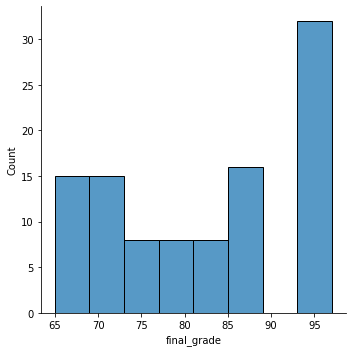

In [67]:
# lets check out some distributions before we move on
# to exploration:
# let's see how normal our target variable is specifically
sns.displot(x='final_grade', data=clean_df);

In [68]:
# takeaway: our target variable isnt exceptionally Normal,
# so we will keep that in our pocket for later
# in the event that we want to utilize an algorithm for modeling
# that is contingent on Normal data

In [70]:
# for my other columns:
columns = list(clean_df.columns)

In [71]:
clean_df.columns

Index(['exam1', 'exam2', 'exam3', 'final_grade'], dtype='object')

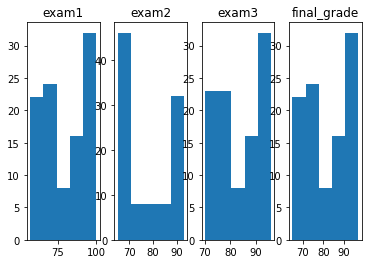

In [73]:
for i, col in enumerate(columns):
    subplot_number = i + 1
    plt.subplot(1,4,subplot_number)
    plt.title(col)
    clean_df[col].hist(bins=5)
    plt.grid(False)

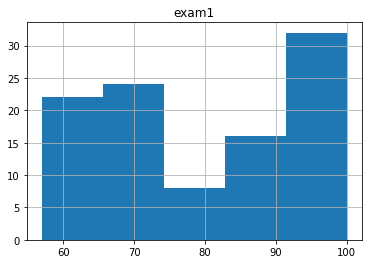

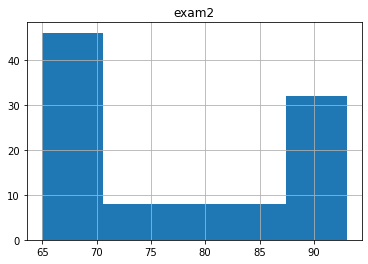

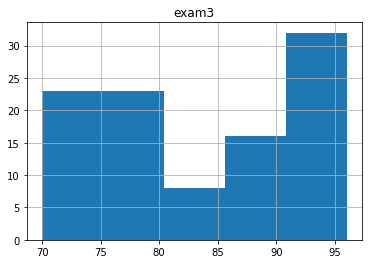

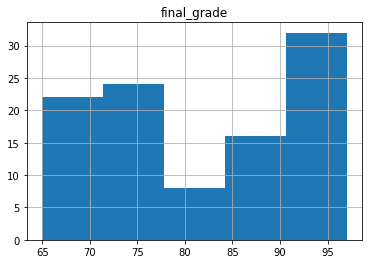

In [75]:
for i, col in enumerate(columns):
    clean_df[col].hist(bins=5)
    plt.title(col)
    plt.show()

In [ ]:
# takeaways:
# all of our grade distributions appear to be
# roughly bimodal:
# that is to say that the students
# in these samples appear to fall into one of two
# different pools of student,
# that may*** represent different populations

# Questions for exploration:
# can we capture the final grades predictably
# utilizing these features?
# does the bimodal distribution of these features
# and the target impact our capacity to use one model?
# does that even matter if the distruibutions of the independent features
# are just as bimodal as the target?